# Project3_1M_MovieLens Data Analysis (Sample Data)

Author : Ashita Chandnani

Sample data : This has 32373 ratings from 5000 users on 100 movies.

Interesting trends : These results have been verified using Excel Power Query and Pivot Tables.

[1. What are the k most popular movies of all times?](#section_1)

[2. What are the k most popular movies of a particular year?](#section_2)

[3. What are the k most popular movies by age group?](#section_3)

[4. What are the k movies with most ratings (presumably popular) with lowest ratings?](#section_4)

[5. What are the top k movies for the specified season?](#section_5)

[6. What is the average rating for each genre?](#section_6)

[7. What is the average rating given by each age group?](#section_7)

[8. What is the average age of users who rated movies in each genre?](#section_8)

[9. What are the top rated movies in each genre?](#section_9)

[10. Which genres are preferred by people with different occupational groups?](#section_10)

[11. Is there a genre preference based on gender?](#section_11)

In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *

In [2]:
# Creating a Spark session
spark = (SparkSession
        .builder
        .appName("Spark SQL Project3 Movie Data Mining Small Dataset 1M")
        .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/06 14:25:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Loading the DataFrames
movie_csv_file = "1M_all/SmallDataInput/movies.csv"
ratings_csv_file = "1M_all/SmallDataInput/ratings.csv"
users_csv_file = "1M_all/SmallDataInput/users.csv"

In [4]:
movies_df = (spark.read.format("csv")
      .option("inferschema", "true")
      .option("header", "true")
      .option("samplingRatio", 0.1)  # Adjust the sampling ratio 
      .load(movie_csv_file))

In [5]:
ratings_df = (spark.read.format("csv")
    .option("inferschema", "true")
    .option("header", "true")
    .option("samplingRatio", 0.1)  # Adjust the sampling ratio
    .load(ratings_csv_file))

In [6]:
users_df = (spark.read.format("csv")
    .option("inferschema", "true")
    .option("header", "true")
    .option("samplingRatio", 0.1)  # Adjust the sampling ratio
    .load(users_csv_file))

In [7]:
movies_df.show(5)

+-------+--------------------+--------------------+
|MovieID|              Titles|              Genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Animation|Childre...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|        Comedy|Drama|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [8]:
movies=movies_df.withColumn("Genre", explode(split(trim(col("Genres")), "\\|")))

In [9]:
movies.show(5)

+-------+----------------+--------------------+----------+
|MovieID|          Titles|              Genres|     Genre|
+-------+----------------+--------------------+----------+
|      1|Toy Story (1995)|Animation|Childre...| Animation|
|      1|Toy Story (1995)|Animation|Childre...|Children's|
|      1|Toy Story (1995)|Animation|Childre...|    Comedy|
|      2|  Jumanji (1995)|Adventure|Childre...| Adventure|
|      2|  Jumanji (1995)|Adventure|Childre...|Children's|
+-------+----------------+--------------------+----------+
only showing top 5 rows



In [10]:
movies=movies.drop('Genres')

In [11]:
movies.show(5)

+-------+----------------+----------+
|MovieID|          Titles|     Genre|
+-------+----------------+----------+
|      1|Toy Story (1995)| Animation|
|      1|Toy Story (1995)|Children's|
|      1|Toy Story (1995)|    Comedy|
|      2|  Jumanji (1995)| Adventure|
|      2|  Jumanji (1995)|Children's|
+-------+----------------+----------+
only showing top 5 rows



In [12]:
ratings_df.show(5)

+------+-------+------+---------+
|UserID|MovieID|Rating|Timestamp|
+------+-------+------+---------+
|     1|      1|     5|978824268|
|     6|      1|     4|978237008|
|     8|      1|     4|978233496|
|     9|      1|     5|978225952|
|    10|      1|     5|978226474|
+------+-------+------+---------+
only showing top 5 rows



In [13]:
users_df.show(5)

+------+------+---+----------+--------+
|UserID|Gender|Age|Occupation|Zip-code|
+------+------+---+----------+--------+
|     1|     F|  1|        10|   48067|
|     2|     M| 56|        16|   70072|
|     5|     M| 25|        20|   55455|
|     6|     F| 50|         9|   55117|
|     7|     M| 35|         1|    6810|
+------+------+---+----------+--------+
only showing top 5 rows



In [14]:
# Joining ratings and users on UserID
movies_ratings_df = movies.join(ratings_df, on="MovieID")

In [15]:
# Joining with movies on MovieID
joined_df = movies_ratings_df.join(users_df, on="UserID")

In [16]:
# Convert the timestamp to a date and extract the month
joined_df = joined_df.withColumn("ReleaseMonth", month(from_unixtime("Timestamp")))

In [17]:
joined_df.createOrReplaceTempView("all_tbl")

In [18]:
spark.sql("Select * from all_tbl limit (5)").show()

+------+-------+----------------+----------+------+---------+------+---+----------+--------+------------+
|UserID|MovieID|          Titles|     Genre|Rating|Timestamp|Gender|Age|Occupation|Zip-code|ReleaseMonth|
+------+-------+----------------+----------+------+---------+------+---+----------+--------+------------+
|     1|      1|Toy Story (1995)|    Comedy|     5|978824268|     F|  1|        10|   48067|           1|
|     1|      1|Toy Story (1995)|Children's|     5|978824268|     F|  1|        10|   48067|           1|
|     1|      1|Toy Story (1995)| Animation|     5|978824268|     F|  1|        10|   48067|           1|
|     6|      1|Toy Story (1995)|    Comedy|     4|978237008|     F| 50|         9|   55117|          12|
|     6|      1|Toy Story (1995)|Children's|     4|978237008|     F| 50|         9|   55117|          12|
+------+-------+----------------+----------+------+---------+------+---+----------+--------+------------+



Now we can write standard SQL queries. These would be no differenet than what we would
do in a standard relational database.

The all_tbl has the data of all 3 tables joined on the common columns:
* MovieID
* UserID

Now we can proceed with answering all our questions using standard SQL statements

# Interesting Trends -

<a id="section_1"></a>
## 1. What are the k most popular movies of all times?

In [19]:
# SQL queries to find k most popular movies of all times

# Define the value of k (number of most popular movies we want to retrieve)
k = 10

result=spark.sql(f"""SELECT MovieID,Titles,Count(*) as RatingCount,
Round(AVG(Rating),2) AS AvgRating
FROM all_tbl
Group By MovieID, Titles
ORDER by RatingCount DESC, AvgRating DESC
LIMIT {k}""")
result.show()

+-------+--------------------+-----------+---------+
|MovieID|              Titles|RatingCount|AvgRating|
+-------+--------------------+-----------+---------+
|      1|    Toy Story (1995)|       6231|     4.15|
|     34|         Babe (1995)|       5253|     3.89|
|     70|From Dusk Till Da...|       4570|     3.16|
|     21|   Get Shorty (1995)|       4068|     3.62|
|     50|Usual Suspects, T...|       3566|     4.52|
|     11|American Presiden...|       3099|     3.79|
|     32|Twelve Monkeys (1...|       3022|     3.95|
|      6|         Heat (1995)|       2820|     3.88|
|     39|     Clueless (1995)|       2724|     3.62|
|     10|    GoldenEye (1995)|       2664|     3.54|
+-------+--------------------+-----------+---------+



This global popularity analysis provides insights into the overall popularity of movies across all genres and years. It identifies movies that have received the highest number of ratings, indicating a broad appeal among users.

Platforms can use this information to understand which movies have resonated the most with their user base. This information about the most popular movies of all time can be used for catalog promotion. 

Highlighting these movies can attract new users and retain existing ones by offering a selection of widely appreciated content.

**Toy story** has most ratings and **Usual suspects** has highest average ratings.

In [20]:
# Specifying the output CSV file path
output_csv_path = "1M_all/SmallDataOutput/Trend_01_most_popular_movies.csv"
# Write the result to the CSV file
result.write.csv(output_csv_path, header=True, mode="overwrite")

## Verified in Excel
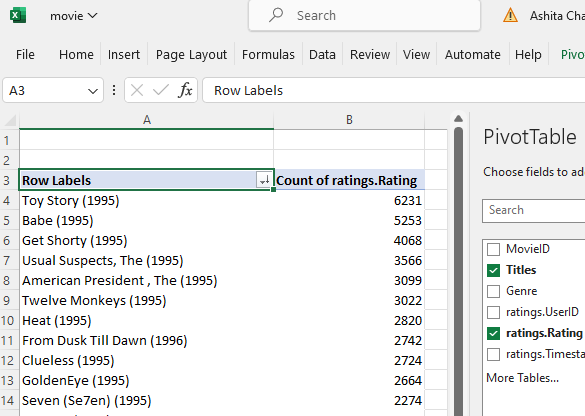

<a id="section_2"></a>
## 2. What are the k most popular movies of a particular year?

In [21]:
# SQL query to find k most popular movies of a particular year

# Define the value of k (number of most popular movies we want to retrieve)
k = 10

# Define the desired year
target_year = 2002  

result=spark.sql(f"""SELECT MovieID,Titles,Count(*) as RatingCount,
Round(AVG(Rating),2) AS AvgRating
FROM all_tbl
WHERE YEAR(FROM_UNIXTIME(Timestamp))=={target_year}
Group By MovieID, Titles
ORDER by RatingCount DESC, AvgRating DESC
LIMIT {k}""")
result.show()

+-------+--------------------+-----------+---------+
|MovieID|              Titles|RatingCount|AvgRating|
+-------+--------------------+-----------+---------+
|     11|American Presiden...|         69|      3.7|
|     10|    GoldenEye (1995)|         69|      3.3|
|     50|Usual Suspects, T...|         68|     4.59|
|      1|    Toy Story (1995)|         51|     4.24|
|     34|         Babe (1995)|         51|     3.88|
|     47|Seven (Se7en) (1995)|         50|     4.08|
|     70|From Dusk Till Da...|         50|      3.3|
|      6|         Heat (1995)|         48|     3.94|
|     32|Twelve Monkeys (1...|         48|     3.92|
|     21|   Get Shorty (1995)|         48|     3.38|
+-------+--------------------+-----------+---------+



The query allows for an annual analysis of the most popular movies, helping content platforms understand the trends and preferences of users during a specific year (e.g., 2002 has most rated **American President**).

Yearly user engagement metrics can help the platforms assess success of their content strategy and make informed decisions for the future.

Users may find value in discovering or revisiting movies that were celebrated during a specific time frame.

Highlighting the top movies of a given year can enhance user satisfaction and keep the catalog diverse and engaging.

In [22]:
# Specifying the output CSV file path
output_csv_path = f"1M_all/SmallDataOutput/Trend_02_most_popular_movies_{target_year}.csv"
# Write the result to the CSV file
result.write.csv(output_csv_path, header=True, mode="overwrite")

<a id="section_3"></a>
## 3. What are the k most popular movies by age group?

In [23]:
# SQL Query to find k most popular movies by age group

# Define the value of k (number of most popular movies we want to retrieve)
k = 10

# Define the desired age group
target_age_group = 25   # it represents  "25-34" age bracket

result=spark.sql(f"""SELECT MovieID,Titles,Count(*) as RatingCount,
Round(AVG(Rating),2) AS AvgRating
FROM all_tbl
WHERE Age=={target_age_group}
Group By MovieID, Titles
ORDER by RatingCount DESC, AvgRating DESC
LIMIT {k}""")
result.show()

+-------+--------------------+-----------+---------+
|MovieID|              Titles|RatingCount|AvgRating|
+-------+--------------------+-----------+---------+
|      1|    Toy Story (1995)|       2370|      4.2|
|     70|From Dusk Till Da...|       2095|     3.11|
|     34|         Babe (1995)|       1920|     3.96|
|     21|   Get Shorty (1995)|       1788|     3.56|
|     50|Usual Suspects, T...|       1564|     4.55|
|     32|Twelve Monkeys (1...|       1360|     3.98|
|      6|         Heat (1995)|       1248|     3.91|
|     11|American Presiden...|       1188|     3.73|
|     10|    GoldenEye (1995)|       1095|     3.44|
|     39|     Clueless (1995)|       1090|     3.65|
+-------+--------------------+-----------+---------+



By focusing on a specific age group (e.g., in 25-34 ages **Toy Story** is most popular), the query aims to provide personalized recommendations tailored to the preferences of users within that age range. 

This is particularly relevant for content platforms seeking to enhance user experience and engagement.

Users are more likely to return to a platform that consistently offers content that aligns with their preferences.

In [24]:
# Specifying the output CSV file path
output_csv_path = f"1M_all/SmallDataOutput/Trend_03_most_popular_movies_{target_age_group}.csv"
# Write the result to the CSV file
result.write.csv(output_csv_path, header=True, mode="overwrite")

### Verified in excel
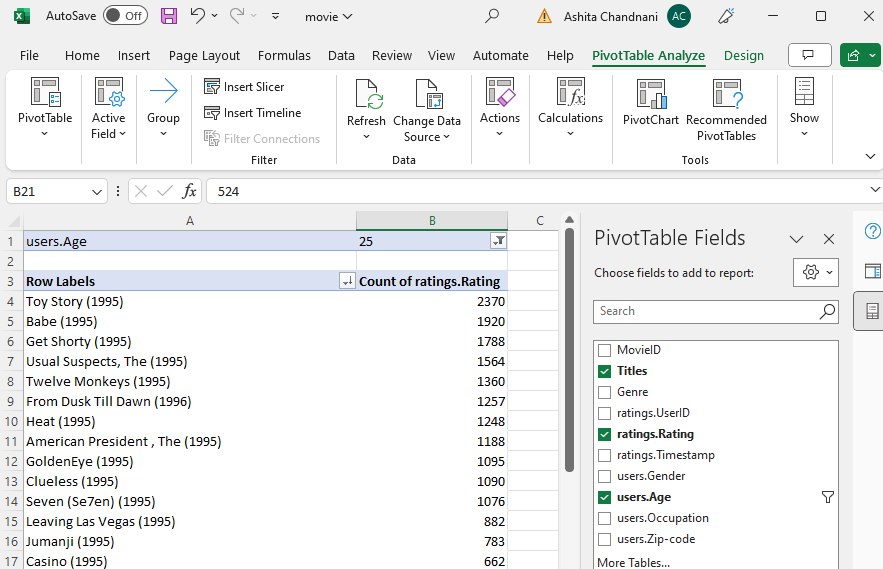

## 4. What are the k movies with most ratings (presumably popular) with lowest ratings?<a id="section_4"></a>

In [25]:
# Define the value of k (number of most popular movies we want to retrieve)
k = 10

# SQL queries to find k movies with most ratings (presumably popular) with lowest Ratings
result=spark.sql(f"""SELECT MovieID,Titles,Round(AVG(Rating),2) as AvgRating,Count(*) as RatingCount
FROM all_tbl
Group By MovieID, Titles
HAVING RatingCount > 1  -- To exclude movies with only one rating
ORDER by RatingCount DESC, AvgRating ASC
LIMIT {k}""")
result.show()

+-------+--------------------+---------+-----------+
|MovieID|              Titles|AvgRating|RatingCount|
+-------+--------------------+---------+-----------+
|      1|    Toy Story (1995)|     4.15|       6231|
|     34|         Babe (1995)|     3.89|       5253|
|     70|From Dusk Till Da...|     3.16|       4570|
|     21|   Get Shorty (1995)|     3.62|       4068|
|     50|Usual Suspects, T...|     4.52|       3566|
|     11|American Presiden...|     3.79|       3099|
|     32|Twelve Monkeys (1...|     3.95|       3022|
|      6|         Heat (1995)|     3.88|       2820|
|     39|     Clueless (1995)|     3.62|       2724|
|     10|    GoldenEye (1995)|     3.54|       2664|
+-------+--------------------+---------+-----------+



The combination of high rating counts and lower average ratings may indicate that certain movies are widely watched but not universally well-received. 

Understanding user engagement with such movies can be crucial for content platforms to refine their recommendation algorithms and content curation strategies.

It present an opportunity for content platforms to analyze user feedback and identify areas for improvement. 

It may also be useful in balancing content recommrndations. While some users may enjoy popular blockbusters, others may prefer movies with niche appeal or unconventional storytelling.

In [26]:
# Specifying the output CSV file path
output_csv_path = "1M_all/SmallDataOutput/Trend_04_top_movies_lowest_ratings.csv"
# Write the result to the CSV file
result.write.csv(output_csv_path, header=True, mode="overwrite")

## 5. What are the top k movies for the specified season?<a id="section_5"></a>


In [27]:
# SQL query to find the top k movies for the specified season

# Define the value of k (number of most popular movies we want to retrieve)
k = 10

# Define the season (1: Winter, 2: Spring, 3: Summer, 4: Fall)
target_season = 3  # Example: 3 for Summer

result=spark.sql(f"""SELECT MovieID,Titles,Round(AVG(Rating),2) as AvgRating,Count(*) as RatingCount
FROM all_tbl
WHERE ReleaseMonth >= {target_season * 3 - 2} AND ReleaseMonth <= {target_season * 3}
Group By MovieID, Titles
HAVING RatingCount > 1  -- To exclude movies with only one rating
ORDER by RatingCount DESC, AvgRating ASC
LIMIT {k}""")
result.show()

+-------+--------------------+---------+-----------+
|MovieID|              Titles|AvgRating|RatingCount|
+-------+--------------------+---------+-----------+
|      1|    Toy Story (1995)|     4.16|       2160|
|     34|         Babe (1995)|      3.9|       1677|
|     70|From Dusk Till Da...|     3.22|       1530|
|     21|   Get Shorty (1995)|     3.63|       1461|
|     50|Usual Suspects, T...|     4.54|       1312|
|     32|Twelve Monkeys (1...|     3.93|       1060|
|      6|         Heat (1995)|     3.95|       1050|
|     39|     Clueless (1995)|     3.59|        966|
|     11|American Presiden...|     3.82|        918|
|     10|    GoldenEye (1995)|     3.62|        915|
+-------+--------------------+---------+-----------+



This SQL query finds the top k movies for a specified season.

Understanding seasonal viewing patterns can be used for seasonal content recommendation. 

In [28]:
# Specifying the output CSV file path
output_csv_path = "1M_all/SmallDataOutput/Trend_05_top_movies_by_seasons.csv"
# Write the result to the CSV file
result.write.csv(output_csv_path, header=True, mode="overwrite")

## 6. What is the average rating for each genre?<a id="section_6"></a>

In [29]:
# SQL query to calculate the average rating for each genre
result=spark.sql("""SELECT Genre,Round(AVG(Rating),2) as AvgRating
FROM 
    (SELECT MovieID,Rating,Genre
    FROM all_tbl)
Group By Genre
ORDER by AvgRating DESC
""")
result.show()

+-----------+---------+
|      Genre|AvgRating|
+-----------+---------+
|        War|     3.96|
|  Animation|     3.94|
|      Crime|     3.91|
| Children's|     3.74|
|   Thriller|     3.68|
|      Drama|     3.66|
|     Sci-Fi|     3.64|
|Documentary|     3.58|
|    Romance|     3.56|
|     Comedy|     3.54|
|  Adventure|     3.34|
|     Action|     3.31|
|    Musical|     3.29|
|    Fantasy|     3.19|
|     Horror|     3.04|
|    Mystery|     2.75|
+-----------+---------+



This query calculates the average rating for each genre by aggregating the ratings of movies within each genre.

This information facilitates data-driven decision-making in the entertainment industry by providing insights into the popularity and user perceptions of different genres. 

Platforms can leverage this information to enhance content curation, user engagement, and overall strategic planning.

**War** stands out with highest average rating and **Mystery** with the lowest average rating.

In [30]:
# Specifying the output CSV file path
output_csv_path = "1M_all/SmallDataOutput/Trend_06_popular_genres.csv"
# Write the result to the CSV file
result.write.csv(output_csv_path, header=True, mode="overwrite")

## Verified in Excel
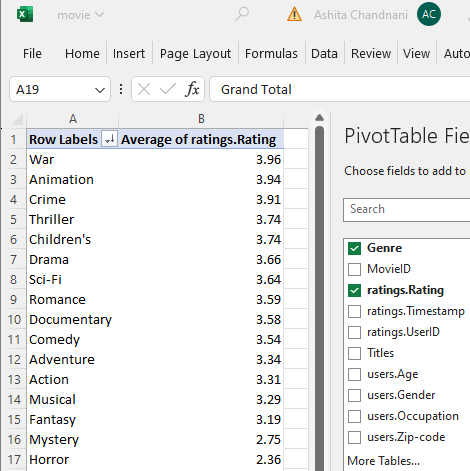

## 7. What is the average rating given by each age group?<a id="section_7"></a>

In [31]:
# SQL query to calculate the average rating by age group
result=spark.sql("""SELECT Age,Round(AVG(Rating),2) as AvgRating
FROM all_tbl
Group By Age
ORDER by Age ASC
""")
result.show()

+---+---------+
|Age|AvgRating|
+---+---------+
|  1|     3.52|
| 18|     3.55|
| 25|     3.58|
| 35|     3.67|
| 45|     3.65|
| 50|     3.68|
| 56|      3.7|
+---+---------+



This query is useful for understanding the average ratings given by users in different age groups. 

Analyzing the average ratings based on age can provide valuable insights into the preferences and satisfaction levels of users across different age demographics.

**Older age groups** tend to give more average ratings.

In [32]:
# Specifying the output CSV file path
output_csv_path = "1M_all/SmallDataOutput/Trend_07_Ratings_by_age.csv"
# Write the result to the CSV file
result.write.csv(output_csv_path, header=True, mode="overwrite")

## Verified in excel
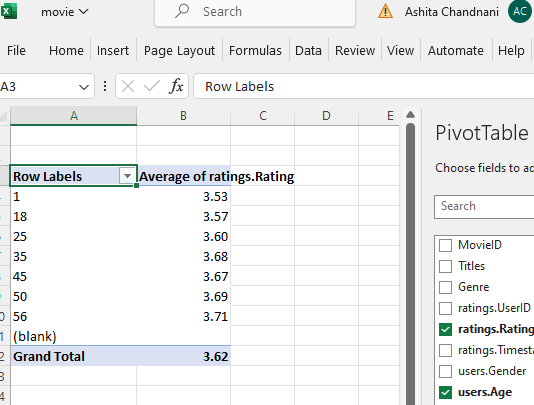

## 8. What is the average age of users who rated movies in each genre?<a id="section_8"></a>

In [33]:
# SQL query to calculate the average age of users who rated movies in each genre
result=spark.sql("""SELECT Genre,Round(AVG(Age),2) as AvgAge
FROM all_tbl
Group By Genre
ORDER by AvgAge DESC
""")
result.show()

+-----------+------+
|      Genre|AvgAge|
+-----------+------+
|        War| 32.27|
|    Romance| 29.89|
|Documentary| 29.78|
|      Drama| 29.75|
|    Mystery| 29.63|
|    Fantasy| 28.47|
| Children's| 28.19|
|     Comedy| 28.14|
|     Sci-Fi| 27.88|
|    Musical| 27.81|
|     Action| 27.62|
|   Thriller| 27.43|
|  Animation| 27.41|
|      Crime| 27.39|
|  Adventure| 27.27|
|     Horror| 26.41|
+-----------+------+



This query is useful to the platform for understanding the average age of users who rate movies in different genres. 

It provides insights into the age demographics of the audience for each genre, which can be valuable for optimizing various aspects of content strategy and user engagements.

Average age of people rating **War** movies is about 32 years.

In [34]:
# Specifying the output CSV file path
output_csv_path = "1M_all/SmallDataOutput/Trend_08_avg_age_by_genres.csv"
# Write the result to the CSV file
result.write.csv(output_csv_path, header=True, mode="overwrite")

## Verified in excel
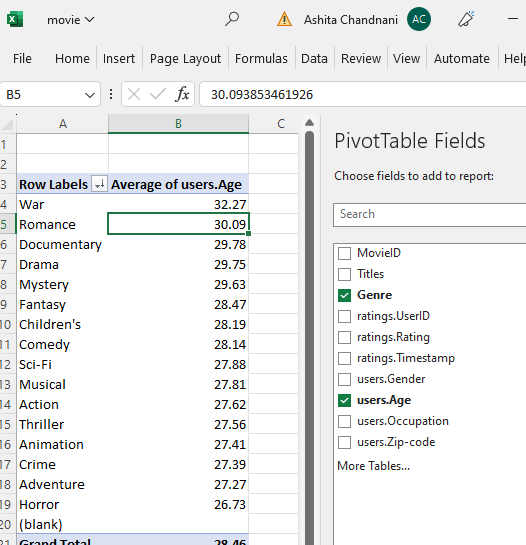

## 9. What are the top rated movies in each genre?<a id="section_9"></a>

In [35]:
# SQL query to find top rated movies in each genre
result=spark.sql("""SELECT
    Genre,
    MovieID,
    Titles,
    Round(AVG(Rating),2) AS AvgRating,
    COUNT(*) AS RatingCount,
    RANK() OVER (PARTITION BY Genre ORDER BY AVG(Rating) DESC,COUNT(*) DESC) AS Ranking
FROM
    all_tbl
GROUP BY
    Genre, MovieID,Titles
ORDER BY
    Genre, Ranking;
""")
result.show(20)

+---------+-------+--------------------+---------+-----------+-------+
|    Genre|MovieID|              Titles|AvgRating|RatingCount|Ranking|
+---------+-------+--------------------+---------+-----------+-------+
|   Action|      6|         Heat (1995)|     3.88|        940|      1|
|   Action|     21|   Get Shorty (1995)|     3.62|       1356|      2|
|   Action|     10|    GoldenEye (1995)|     3.54|        888|      3|
|   Action|     70|From Dusk Till Da...|     3.16|        914|      4|
|   Action|     89| Nick of Time (1995)|     3.07|        229|      5|
|   Action|     95| Broken Arrow (1996)|     2.88|        638|      6|
|   Action|     42|Dead Presidents (...|     2.87|        221|      7|
|   Action|     44|Mortal Kombat (1995)|     2.79|        311|      8|
|   Action|      9| Sudden Death (1995)|     2.66|        102|      9|
|   Action|     20|  Money Train (1995)|     2.54|        160|     10|
|   Action|     15|Cutthroat Island ...|     2.46|        146|     11|
|   Ac

The above query calculates the average rating, rating count, and ranking for each movie by genre. It uses the RANK() window function to rank movies within each genre based on the average rating and count of ratings.

This information can be useful top recommend top rated movies in each genre to users who show an interest in a specific genre.

**Heat** and **Get Shorty** are top rated in Action Genre.

In [36]:
# Specifying the output CSV file path
output_csv_path = "1M_all/SmallDataOutput/Trend_09_toprated_mostratedmovies_by_genres.csv"
# Write the result to the CSV file
result.write.csv(output_csv_path, header=True, mode="overwrite")

## Verified in Excel
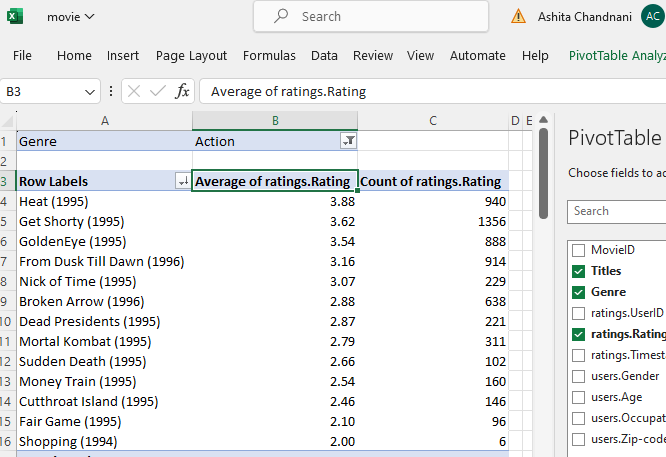

## 10. Which genres are preferred by people with different occupational groups?<a id="section_10"></a>

In [37]:
# SQL query to calculate the genres preffered by people with different occupational groups
result=spark.sql("""
WITH OccupationGenres AS (
    SELECT
        UserID,
        MovieID,
        Titles,
        Genre,
        Rating,
        Occupation,
        CASE
            WHEN Occupation = 0 THEN 'other'
            WHEN Occupation = 1 THEN 'academic/educator'
            WHEN Occupation = 2 THEN 'artist'
            WHEN Occupation = 3 THEN 'clerical/admin'
            WHEN Occupation = 4 THEN 'college/grad student'
            WHEN Occupation = 5 THEN 'customer service'
            WHEN Occupation = 6 THEN 'doctor/health care'
            WHEN Occupation = 7 THEN 'executive/managerial'
            WHEN Occupation = 8 THEN 'farmer'
            WHEN Occupation = 9 THEN 'homemaker'
            WHEN Occupation = 10 THEN 'K-12 student'
            WHEN Occupation = 11 THEN 'lawyer'
            WHEN Occupation = 12 THEN 'programmer'
            WHEN Occupation = 13 THEN 'retired'
            WHEN Occupation = 14 THEN 'sales/marketing'
            WHEN Occupation = 15 THEN 'scientist'
            WHEN Occupation = 16 THEN 'self-employed'
            WHEN Occupation = 17 THEN 'technician/engineer'
            WHEN Occupation = 18 THEN 'tradesman/craftsman'
            WHEN Occupation = 19 THEN 'unemployed'
            WHEN Occupation = 20 THEN 'writer'
            ELSE 'unknown'
        END AS OccupationGroup
    FROM
        all_tbl)
SELECT
    OccupationGroup,
    Genre,
    ROUND(AVG(Rating),2) AS AvgRating
FROM
    OccupationGenres
GROUP BY
    OccupationGroup, Genre
ORDER BY
    OccupationGroup, AvgRating DESC

""")
result.show(40)

+-----------------+-----------+---------+
|  OccupationGroup|      Genre|AvgRating|
+-----------------+-----------+---------+
|     K-12 student|      Crime|      4.0|
|     K-12 student|   Thriller|     3.81|
|     K-12 student|  Animation|     3.69|
|     K-12 student|        War|     3.67|
|     K-12 student|      Drama|     3.59|
|     K-12 student|     Sci-Fi|     3.55|
|     K-12 student|     Action|     3.46|
|     K-12 student|    Musical|     3.43|
|     K-12 student|     Comedy|     3.43|
|     K-12 student| Children's|     3.41|
|     K-12 student|  Adventure|     3.39|
|     K-12 student|    Romance|     3.38|
|     K-12 student|    Fantasy|     3.24|
|     K-12 student|     Horror|     3.21|
|academic/educator|  Animation|     4.01|
|academic/educator|        War|     3.97|
|academic/educator| Children's|     3.86|
|academic/educator|      Crime|     3.82|
|academic/educator|     Sci-Fi|     3.72|
|academic/educator|      Drama|     3.64|
|academic/educator|    Romance|   

The above query provides information on the preferred genres for different occupation groups based on the average ratings given by users in those groups.

This information can be used to provide personalized content suggestions, user engagement and marketing strategies for users in specific professions and improve overall user experience in diverse occuptional groups.

**Crime, thriller, animation** have highest average rating in the student group.

In [38]:
# Specifying the output CSV file path
output_csv_path = "1M_all/SmallDataOutput/Trend_10_Preferred_genres_by_occupation.csv"

In [39]:
# Write the result to the CSV file
result.write.csv(output_csv_path, header=True, mode="overwrite")

## Verified in Excel
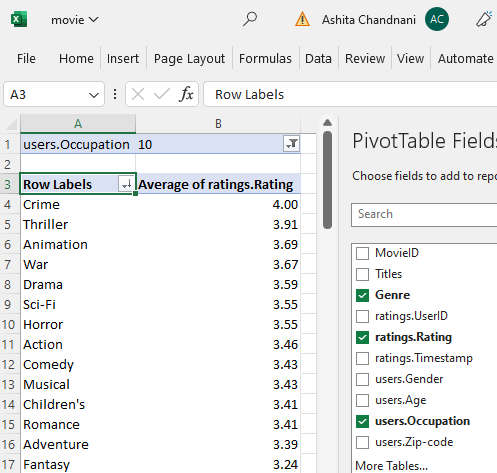

## 11. Is there a genre preference based on gender?<a id="section_11"></a>

In [40]:
# Trend 11: Genre Preference Comparison between Male and Female Users
result = spark.sql("""
    SELECT
        Genre,
        Round(AVG(CASE WHEN Gender = 'M' THEN Rating END),2) AS AvgRatingMale,
        Round(AVG(CASE WHEN Gender = 'F' THEN Rating END),2) AS AvgRatingFemale,
        COUNT(CASE WHEN Gender = 'M' THEN 1 END) AS MaleCount,
        COUNT(CASE WHEN Gender = 'F' THEN 1 END) AS FemaleCount
    FROM
        all_tbl
    GROUP BY
        Genre
    ORDER BY
        Genre
""")
result.show()


+-----------+-------------+---------------+---------+-----------+
|      Genre|AvgRatingMale|AvgRatingFemale|MaleCount|FemaleCount|
+-----------+-------------+---------------+---------+-----------+
|     Action|         3.32|           3.24|     5056|        951|
|  Adventure|         3.33|           3.38|     2499|        624|
|  Animation|         3.93|           3.96|     1782|        776|
| Children's|         3.71|            3.8|     3854|       1707|
|     Comedy|          3.5|           3.64|     8988|       3708|
|      Crime|         3.92|           3.87|     4420|       1119|
|Documentary|         3.62|           3.46|       66|         26|
|      Drama|         3.65|           3.69|    10614|       4754|
|    Fantasy|         3.17|           3.28|      784|        283|
|     Horror|         3.09|           2.76|      906|        168|
|    Musical|         3.22|            3.4|      370|        236|
|    Mystery|          3.0|            1.0|        7|          1|
|    Roman

This information is useful to gain insights into whether there are variations in genre preferences between different genders.

It also allows quantifying the differences in user engagement between male and female users for each genre.

**Drama** and **Comedy** is the most frequently rated genre by both male and female users.

**Documentary** and **Myster** have relatively lower counts of ratings and the ratings are slightly higher from male users compared to female users.

**War** movies have relatively fewer ratings compared to other genres, but they have high average ratings from both males and females. This indicates that those who watch war movies tend to rate them higher.

**Sci-fi, Thriller, Childrens, Animation, Romance** have high average ratings from both genders with substantial amounts of ratings meaning they are well recieved by all.

**Horror** seems to be less popular in females, more and higher ratings are given by males.

In [41]:
# Specifying the output CSV file path
output_csv_path = "1M_all/SmallDataOutput/Trend_11_Preferred_genres_by_gender.csv"

In [42]:
# Write the result to the CSV file
result.write.csv(output_csv_path, header=True, mode="overwrite")

In [43]:
spark.stop()